## Importing the Libraries

In [3]:
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from wordcloud import WordCloud
import string
import pickle

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/debaratnanath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/debaratnanath/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/debaratnanath/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/debaratnanath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/debaratnanath/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Loading the Data
## Initial Data Analysis

In [4]:
# importing dataset
reviews_df = pd.read_csv("data/sample30.csv")
reviews_df.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


### Initial Analysis

In [5]:
print(f"Shape of the Data: {reviews_df.shape}")

Shape of the Data: (30000, 15)


In [6]:
reviews_df.describe()

,reviews_rating
count,30000.00
mean,4.48
std,0.99
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


In [7]:
reviews_df.dtypes

id                      object
brand                   object
categories              object
manufacturer            object
name                    object
reviews_date            object
reviews_didPurchase     object
reviews_doRecommend     object
reviews_rating           int64
reviews_text            object
reviews_title           object
reviews_userCity        object
reviews_userProvince    object
reviews_username        object
user_sentiment          object
dtype: object

### Missing Values in the Data

In [8]:
def calculate_na(df):
    df_na = pd.DataFrame(np.round(df.isna().sum()/df.shape[0] * 100, 2)).reset_index()
    df_na.rename(columns = {'index': 'Columns', 0: 'Missing Value Percentage'}, inplace =True)
    df_na = df_na.sort_values(by = ['Missing Value Percentage'], ascending = False)

    df_na_total = pd.DataFrame(df.isna().sum()).reset_index().rename(columns = {'index': 'Columns', 0: 'Missing Value Total'})
    df_na = df_na.merge(df_na_total, on = ['Columns'], how = 'left')
    return df_na

calculate_na(reviews_df)

,Columns,Missing Value Percentage,Missing Value Total
0,reviews_userProvince,99.43,29830
1,reviews_userCity,93.57,28071
2,reviews_didPurchase,46.89,14068
3,reviews_doRecommend,8.57,2570
4,reviews_title,0.63,190
5,manufacturer,0.47,141
6,reviews_username,0.21,63
7,reviews_date,0.15,46
8,id,0.00,0
9,brand,0.00,0


In [9]:
reviews_df = reviews_df[~reviews_df.user_sentiment.isnull()]

In [10]:
reviews_df['user_sentiment'].value_counts()

user_sentiment
Positive    26632
Negative     3367
Name: count, dtype: int64

In [11]:
reviews_df['user_sentiment'] = reviews_df['user_sentiment'].map({'Positive': 1, 'Negative': 0})

### Visualising User Sentiments and Ratings

In [12]:
# visualising the distribution
def visualise_countplot(df, column, figsize = (15, 6)):
    plt.figure(figsize = figsize)
    fig = sns.countplot(df, x = column).set_title(f"Countplot: {column}")
    return fig

Text(0.5, 1.0, 'Countplot: user_sentiment')

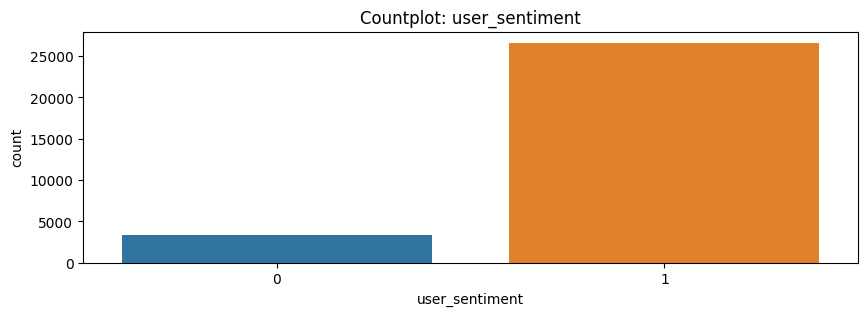

In [13]:
visualise_countplot(reviews_df, "user_sentiment", figsize = (10, 3))

Text(0.5, 1.0, 'Countplot: reviews_rating')

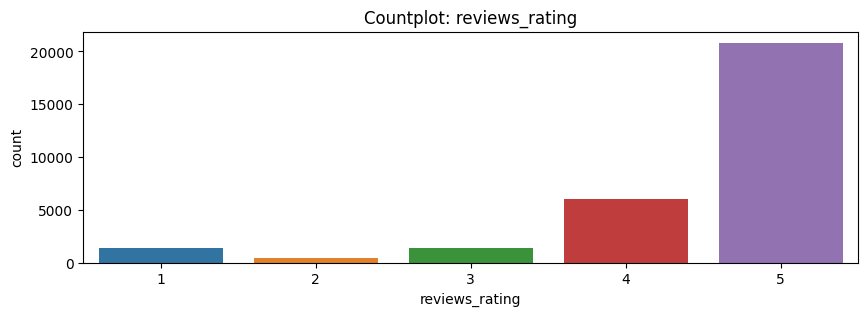

In [14]:
visualise_countplot(reviews_df, "reviews_rating", figsize = (10, 3))

---

### Inference

- Both user ratings and sentiments are highly imbalanced. 
- Need to probably perform oversampling to take care of the class imbalance

## Analysing Data Quality Issues in the user reviews/ratings

- Ideally, users who review the product with a positive sentiment should rate the product highly (>=4), and users who review the product with a negative sentiment should rate the product low (< 3)
- Check for instances where the logic contradicts

---

In [15]:
pd.crosstab(reviews_df["user_sentiment"], reviews_df["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,597,140,220,550,1860,3367
1,787,280,1125,5470,18970,26632
All,1384,420,1345,6020,20830,29999


---

### Inference

- 550 users who rated the product with a rating 4 had a negative sentiment about the product
- 1860 users who rated the product with a rating 4 had a negative sentiment about the product
- 787 users who rated the product with a rating 1 had a positive sentiment about the product
- 280 users who rated the product with a rating 2 had a positive sentiment about the product


In [16]:
#Looking at a sample data where reviews are positive but rating is less than 3

df_pos_reviews_quality = reviews_df[(reviews_df['user_sentiment'] == 1) & (reviews_df['reviews_rating']<3)][['reviews_rating', 'reviews_text', 'reviews_title', 'user_sentiment']]
df_pos_reviews_quality.sample(5)

,reviews_rating,reviews_text,reviews_title,user_sentiment
21405,1,"This new formula of gel is terrible! The smell is too strong, and it dries my hair out! The old formula was fantastic! Bring it back! I have long naturally curly hair, and the old gel worked perfectly to keep away the frizz. It made my curls defined and my hair looked wonderful! It's hard findin...",Hate the new formula!!!!,1
28822,1,I can see this working AMAZINGLY for someone with normal thickness and coarseness. Between the mask and shampoo it was too much for my already dry damaged ends. i did receive this product for free in exchange for a review however all opinions are my own. This review was collected as part of a pr...,Wrong for me,1
22398,1,I don't like any of the new formulas they are not as good as they used to be. I miss everything about the old formulas. Specially strong lengths. So sad everything was change. I hope they bring them back soon!!,Not good as it used to be.,1
28854,2,"Despite using this with the line's hair mask and shampoo, I didn't find much difference in oil control the next day and still felt the need to use dry shampoo. It smells nice and made my hair feel soft, but it just didn't live up to all of its promises, in my opinion. Such a shame too because I ...",I really wanted to love this but...,1
21474,1,A couple years ago I tried the Nexxus Exxtra Gel and it was the best gel I had ever used. I was an instant fan and became a loyal customer of this and some of the other Nexxus products. I would brag about Nexxus anytime a stylist asked me to try something different. Unfortunately I'm no longer a...,A loyal customer no more!,1


In [17]:
#Wordcloud analysis
def display_wordcloud(df, column):
    stop_words = set(stopwords.words('english'))
    df[column] = df[column].str.lower()
    wordcloud = WordCloud(stopwords=stop_words,max_words=200).generate(str(df[column]))
    print(wordcloud)
    plt.figure(figsize= (8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show();


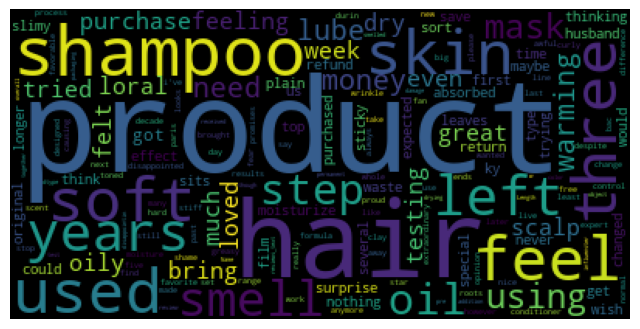

In [18]:
#WORDCLOUD OF USER REVIEWS

display_wordcloud(df_pos_reviews_quality, 'reviews_text')

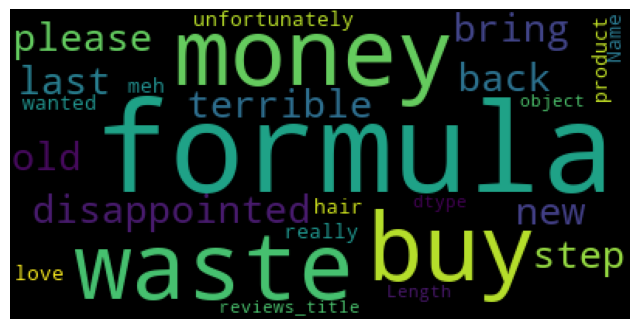

In [19]:
# WORD CLOUD OF USER REVIEWS TITLE

display_wordcloud(df_pos_reviews_quality, 'reviews_title')

---

## Inference

- Looking at the sample data and the wordcloud of the reviews titles, it can be seen that the reviews were actually negative but the sentence was probably phrased in such a way that the sentiment label came out as positive
- Need to correct the sentiment to '0'

---

In [20]:
#Looking at a sample data where reviews are negative but rating is more than or equal to 4

df_neg_reviews_quality = reviews_df[(reviews_df['user_sentiment'] == 0) & (reviews_df['reviews_rating']>=4)][['reviews_rating', 'reviews_text', 'reviews_title', 'user_sentiment']]
df_neg_reviews_quality.sample(5)

,reviews_rating,reviews_text,reviews_title,user_sentiment
10161,5,"It does an amzing job with NO stickiness, germs, or lint left behind. We use nothing else for sinks and counters",Perfect wipe,0
647,5,This moisturizer has a tacky feel on the skin and it helps my foundation stay on all day,Great primer!,0
4476,5,"We have hardwood floor, carpet, carpeted stairs and tile and wanted a lightweight vacuum cleaner that could be used everywhere. This Hoover does it all and with minimal effort!",Love This Vacuum Cleaner!,0
14223,5,My family loves the smell of this disenfecting product. We can and do use them anywhere!,Love the smell,0
985,5,this one saves me money when my bottle(spray bottle empty's ) I refill with this last a lot longer,save money buying this product,0


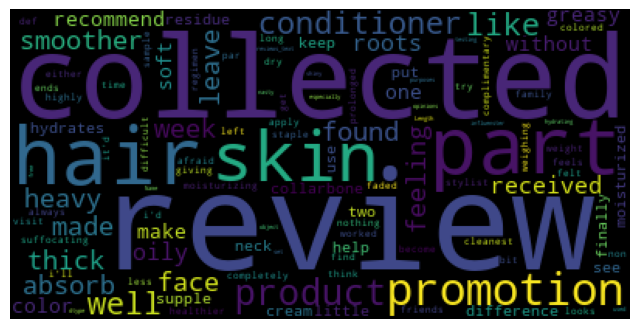

In [21]:
#WORDCLOUD OF USER REVIEWS

display_wordcloud(df_neg_reviews_quality, 'reviews_text')

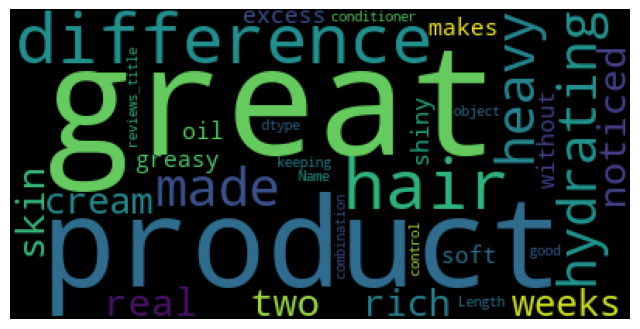

In [22]:
# WORD CLOUD OF USER REVIEWS TITLE

display_wordcloud(df_neg_reviews_quality, 'reviews_title')

---

## Inference

- Looking at the sample data and the wordcloud of the reviews titles, it can be seen that the reviews were actually positive but the sentence was probably phrased in such a way that the sentiment label came out as negative
- Need to correct the sentiment to '1'

## Change Incorrect labels based on Above Analysis

In [23]:
reviews_df.loc[(reviews_df["user_sentiment"]==1) & (reviews_df["reviews_rating"]<3), "user_sentiment"] = 0
reviews_df.loc[(reviews_df["user_sentiment"]==0) & (reviews_df["reviews_rating"]>=4), "user_sentiment"] = 1

---

# Sentiment Analysis

In [25]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [55]:
def clean_text(text):
    '''Function for text cleaning.'''
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    return text

def remove_puncts(text):
    '''Function for removing punctuations
    '''
    text = "".join([c for c in text if c not in string.punctuation])
    return text

def remove_stopword(text):
    '''Function for removing stopwords
    '''
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

def get_wordnet_pos(tag):
    '''Function for getting POS tags
    '''
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatize_text(text):
    '''Function for lemmatizing text
    '''
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(words)

def preprocess_text(text):
    '''Function for text preprocessing
    Performs Text Cleaning, Stopword Removal,
    Text Lemmatization, Remove Punctuations
    
    Returns preprocessed text
    '''
    text_cleaned= clean_text(text)
    text_stopword_removed = remove_stopword(text_cleaned)
    text_lemmatized = lemmatize_text(text_stopword_removed)
    text_processed = remove_puncts(text_lemmatized)
    return text_processed

In [56]:
df_sentiments = reviews_df[['id', 'name', 'reviews_text', 'user_sentiment']].copy()
df_sentiments['text_preprocessed'] = df_sentiments['reviews_text'].apply(lambda x: preprocess_text(x))
df_sentiments.sample(5)

,id,name,reviews_text,user_sentiment,text_preprocessed
11838,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,I clean house and take care of two pre-school boys for a living. Clorox wipes (as well as the toilet wand!) are my go-to for disinfecting the bathroom. What a great way to keep my little charges germ-free! This review was collected as part of a promotion.,1,clean house take care two boy clorox wipe well toilet disinfect great way keep little charge review collect part
5413,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),The show is unique. I'll give it that. But just not the Sci-Fi show for me.,0,show give show
20804,AVpfLnfPLJeJML434HpK,"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201",came with a couple of cracked bricks but they sent new ones out within 3 days. I went through the break in heating and all was well until my first full fire. the paint started flaking off all over the top of it. it was reading 370 degrees with a digital thermometer. exhaust pipe was 310 so even ...,0,come couple cracked brick send new one within go break heating well first full paint start flake top reading degree digital exhaust pipe even vent fully close say fully heat efficient burn low good hr full load dry season glass get dirty decent build already look yrs old within first week operat...
7081,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,I buy these all the time! perfect for young kids and cleaning up after lunch and even toy clean up,1,buy perfect young kid clean lunch even toy clean
13459,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"When you have little kids, you HAVE to have Clorox wipes handy to disinfect everything, especially when everybody is sick at home during winter time! This review was collected as part of a promotion.",1,little clorox wipe handy disinfect especially everybody sick home winter review collect part


In [57]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9, min_df=7, binary=False, 
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_sentiments['text_preprocessed'])

y= df_sentiments['user_sentiment']

In [58]:
# splitting into test and train

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

## Oversampling with SMOTE

In [59]:
counter = Counter(y_train)
print('Before Sampling: ',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After Sampling: ',counter)

Before Sampling:  Counter({1: 20986, 0: 1513})
After Sampling:  Counter({0: 20986, 1: 20986})


---

In [32]:
class ModelBuild:
    """Model Builder Class for implementing scikit learn compatible models.
    
    :Class Attributes:
    
    - model: Any scikit-learn model or compatible ones like XGBoost
    - X_train, X_test, y_train, y_test: Train and Test data split into
    dependent and independent variables accordingly.
    
    :Class Methods:
    
    - get_predictions(): Method for training the model and
    returning predictions on test dataset
    
    - evaluate_model(): Method for showing the model performance
    scores, classification report and confusion matrix
    
    - _get_model_scores(): Helper method for evaluate_model().
    Returns the performance score dictionary containing accuracy
    score, precision, recall, f1 and roc_auc_score
    
    - _get_confusion_matrix(): Helper method for evaluate_model().
    Returns the confusion matrix on test data
    
    - _plot_confusion_matrix(): Helper method for evaluate_model().
    Plots the confusion matrix on test data
    
    - _get_classification_report(): Helper method for evaluate_model().
    Returns the classification report for the model on test data.
    """
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    
    def get_predictions(self):
        self.model.fit(self.X_train, self.y_train)
        return self.model.predict(self.X_test)
    
    
    def _get_model_scores(self, y_pred):
        result_metrics = {} 
        accuracy_score = metrics.accuracy_score(self.y_test, y_pred)
        precision_score = metrics.precision_score(self.y_test, y_pred)
        recall_score = metrics.recall_score(self.y_test, y_pred)
        f1_score = metrics.f1_score(self.y_test, y_pred)
        y_pred_prob = self.model.predict_proba(self.X_test)[:,1]
        roc_auc_score = metrics.roc_auc_score(self.y_test, y_pred)
        
        
        result_metrics['Accuracy Score'] = accuracy_score
        result_metrics['Precision Score'] = precision_score
        result_metrics['Recall Score'] = recall_score
        result_metrics['F1 Score'] = f1_score
        result_metrics['ROC AUC Score'] = roc_auc_score
        
        return result_metrics
    
    def _get_confusion_matrix(self, y_pred):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred)
        self._plot_confusion_matrix(confusion_matrix,[0,1])
        
        
    def _plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")
 
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
 
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()
        
    def _get_classification_report(self, y_pred):
        print(metrics.classification_report(self.y_test, y_pred))
        
    
    def evaluate_model(self, y_pred):
        evaluation_metrics = self._get_model_scores(y_pred)
        print("#"*50)
        for key in evaluation_metrics.keys():
            print(f"{key}: {evaluation_metrics[key]*100:.1f}%")
        print("#"*50)
        print("\n")
        print("CLASSIFICATION REPORT: \n")
        self._get_classification_report(y_pred)
        print("#"* 50)
        print("\n CONFUSION METRICS: \n")
        self._get_confusion_matrix(y_pred)
        
        return evaluation_metrics
        
        
        
        

---

## XGBoost Classifier

##################################################
Accuracy Score: 91.8%
Precision Score: 97.5%
Recall Score: 93.7%
F1 Score: 95.5%
ROC AUC Score: 80.3%
##################################################


CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.44      0.67      0.53       511
           1       0.97      0.94      0.96      6989

    accuracy                           0.92      7500
   macro avg       0.71      0.80      0.74      7500
weighted avg       0.94      0.92      0.93      7500

##################################################

 CONFUSION METRICS: 



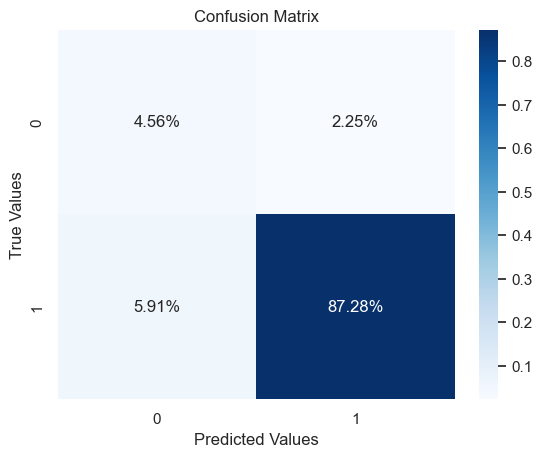

In [62]:
xgb_classifier = XGBClassifier()
xgb_model = ModelBuild(xgb_classifier, X_train, X_test, y_train, y_test)

y_pred  = xgb_model.get_predictions()
xgb_metrics = xgb_model.evaluate_model(y_pred)

---

## Naive Bayes Classifier

##################################################
Accuracy Score: 87.6%
Precision Score: 98.2%
Recall Score: 88.4%
F1 Score: 93.0%
ROC AUC Score: 82.8%
##################################################


CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.33      0.77      0.46       511
           1       0.98      0.88      0.93      6989

    accuracy                           0.88      7500
   macro avg       0.65      0.83      0.69      7500
weighted avg       0.94      0.88      0.90      7500

##################################################

 CONFUSION METRICS: 



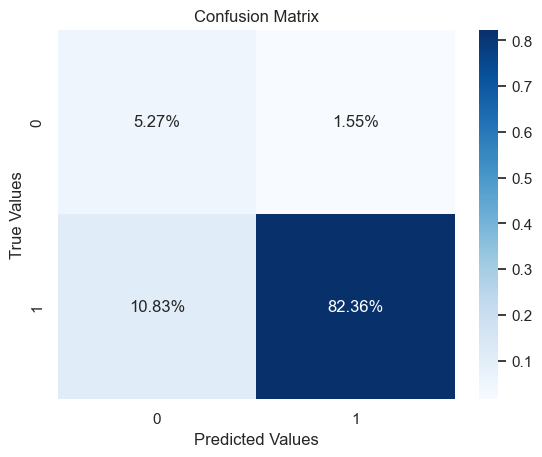

In [63]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB

naivebayes_clf = MultinomialNB(alpha=1.0)
naivebayes_model = ModelBuild(naivebayes_clf, X_train, X_test, y_train, y_test)

# Train and Predict the Test Labels
y_pred  = naivebayes_model.get_predictions()
nb_metrics = naivebayes_model.evaluate_model(y_pred)

---

## Logistic Regression

##################################################
Accuracy Score: 90.2%
Precision Score: 98.1%
Recall Score: 91.2%
F1 Score: 94.5%
ROC AUC Score: 83.4%
##################################################


CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.39      0.76      0.51       511
           1       0.98      0.91      0.95      6989

    accuracy                           0.90      7500
   macro avg       0.68      0.83      0.73      7500
weighted avg       0.94      0.90      0.92      7500

##################################################

 CONFUSION METRICS: 



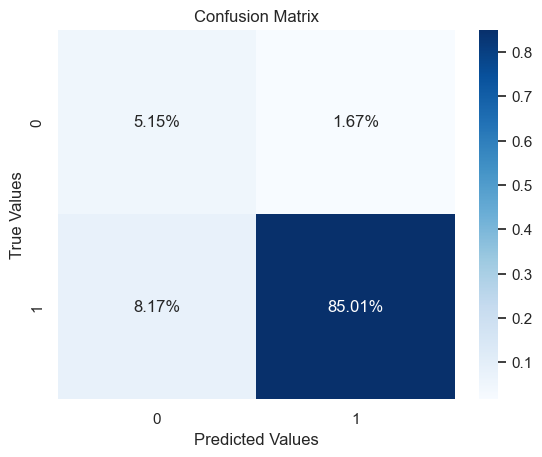

In [64]:
logistic_clf = LogisticRegression()
logistic_model = ModelBuild(logistic_clf, X_train, X_test, y_train, y_test)

# Train and Predict the Test Labels
y_pred  = logistic_model.get_predictions()
logistic_metrics = logistic_model.evaluate_model(y_pred)

---

## Random Forest Classifier

##################################################
Accuracy Score: 95.4%
Precision Score: 97.0%
Recall Score: 98.1%
F1 Score: 97.6%
ROC AUC Score: 78.2%
##################################################


CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       511
           1       0.97      0.98      0.98      6989

    accuracy                           0.95      7500
   macro avg       0.83      0.78      0.80      7500
weighted avg       0.95      0.95      0.95      7500

##################################################

 CONFUSION METRICS: 



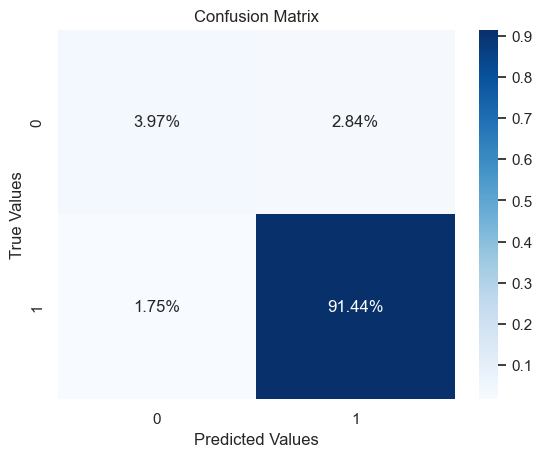

In [65]:
rf_clf = RandomForestClassifier(random_state=10)
rf_model = ModelBuild(rf_clf, X_train, X_test, y_train, y_test)

# Train and Predict the Test Labels
y_pred  = rf_model.get_predictions()
rf_metrics = rf_model.evaluate_model(y_pred)

---

## Inference

- Random Forest has overall better performance (better accuracy, recall and f1 score)

---

### Hyperparameter Tuning

<h3 style="color:Red;"> WARNING!! This section takes around 20-25 minutes to run..! </h3>

In [39]:
from sklearn.model_selection import GridSearchCV

In [44]:
params_rf = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,6,7,8, 10],
    'criterion' :['gini', 'entropy'],
    'random_state' : [10]
}

rf_optimised = GridSearchCV(estimator=rf_clf, param_grid=params_rf, cv= 5,verbose = 1)
rf_optimised.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 10],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200, 500],
                         'random_state': [10]},
             verbose=1)

In [46]:
rf_optimised.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500,
 'random_state': 10}

##################################################
Accuracy Score: 88.8%
Precision Score: 97.5%
Recall Score: 90.3%
F1 Score: 93.7%
ROC AUC Score: 79.1%
##################################################


CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.34      0.68      0.45       511
           1       0.97      0.90      0.94      6989

    accuracy                           0.89      7500
   macro avg       0.66      0.79      0.69      7500
weighted avg       0.93      0.89      0.90      7500

##################################################

 CONFUSION METRICS: 



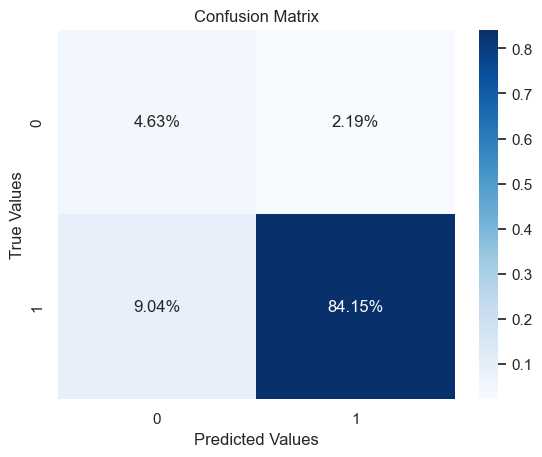

In [48]:
rf_best_clf = RandomForestClassifier(**rf_optimised.best_params_)


rf_best_model = ModelBuild(rf_best_clf, X_train, X_test, y_train, y_test)

# Train and Predict the Test Labels
y_pred  = rf_best_model.get_predictions()
rf_optimised_metrics = rf_best_model.evaluate_model(y_pred)

---

## Inference

- Optimising the RF model results in marginal improvement in Precision and ROC AUC scores, but all the other metrics deteriorate, especially the accuracy score which drops from 95.5% to 88.8%.
- RF base model is the chosen model for creating the sentiment based recommender system

In [49]:
def save_pickle(obj, filename):
    """
    Function for serialising objects
    to a pickle file.
    """
    filename = "pickle/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [52]:
save_pickle(rf_model.model, "randomforest_model")

---
---

<h1 align = center> Recommender System </h1>

---
---

In [66]:
reviews_df[["id", "name", "reviews_rating", "reviews_username"]].to_csv("data/processed/recommendation_clean_data.csv", index = False)

In [67]:
df_recommendation = reviews_df[["id", "name", "reviews_rating", "reviews_username"]].copy()
df_recommendation.head()

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


In [68]:
calculate_na(df_recommendation)

,Columns,Missing Value Percentage,Missing Value Total
0,reviews_username,0.21,63
1,id,0.00,0
2,name,0.00,0
3,reviews_rating,0.00,0


In [69]:
df_recommendation = df_recommendation[~df_recommendation['reviews_username'].isna()]


In [70]:
df_recommendation.to_csv("recommendersys_data.csv", index = False)

In [71]:
train, test = train_test_split(df_recommendation, test_size=0.2, random_state=42)

In [72]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [73]:
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(5)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,...,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

In [74]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,...,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

### Creating dummy dataframes for evaluation

In [75]:
dummy_train = train.copy()
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,...,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

### User-User Similarity Matrix

In [76]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity


In [77]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.00481504 -0.00481504 ... -0.00481504  0.94856354
  -0.00481504]
 [-0.00481504  1.          1.         ... -0.00380228 -0.00380228
  -0.00380228]
 [-0.00481504  1.          1.         ... -0.00380228 -0.00380228
  -0.00380228]
 ...
 [-0.00481504 -0.00380228 -0.00380228 ...  1.         -0.00380228
   1.        ]
 [ 0.94856354 -0.00380228 -0.00380228 ... -0.00380228  1.
  -0.00380228]
 [-0.00481504 -0.00380228 -0.00380228 ...  1.         -0.00380228
   1.        ]]


In [126]:
def get_user_final_rating():
    """Function for creating the user-user
    recommendation engine and returning the
    user rating matrix
    """
    df_recommendation = reviews_df[["id", "name", "reviews_rating", "reviews_username"]].copy()
    df_recommendation = df_recommendation[~df_recommendation['reviews_username'].isna()]
    train, test = train_test_split(df_recommendation, test_size=0.2, random_state=42)
    product_column = "id"
    user_column = "reviews_username"
    value_column = "reviews_rating"
    df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
    mean = np.nanmean(df_pivot, axis=1)
    df_subtracted = (df_pivot.T-mean).T
    dummy_train = train.copy()
    dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)
    dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
    user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
    user_correlation[np.isnan(user_correlation)] = 0
    user_correlation[user_correlation<0]=0
    user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
    user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
    return user_final_rating

def get_recommendations_for_user(user_id, top_k = 20):
    """Function for getting the top-k recommendations
    for input user ID
    """
    user_final_rating = get_user_final_rating()
    recommendations = user_final_rating.loc[user_id].sort_values(ascending=False)[0:top_k]
    final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
    final_recommendations.reset_index(drop=True)
    final_df = pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()
    return final_df

In [127]:
get_recommendations_for_user("08dallas", top_k = 5)

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,26.96
2623,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),23.72
3529,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8.39
10297,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),6.34
10910,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5.60


### Prediction

In [80]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.94856354,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.94856354, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ]])

In [81]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 1.17620846, ..., 0.        , 0.        ,
        0.54040172],
       [0.        , 0.        , 2.44761112, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.44761112, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.87575416],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.57131997],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.87575416]])

In [82]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,...,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

In [83]:
user_input = "08dallas" 

recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()


,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,26.96
2623,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),23.72
3529,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8.39
10297,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),6.34
10910,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5.60
11456,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),5.03
12129,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Coverage",4.31
12261,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,4.19
12417,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,3.63
14079,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,3.53


### Evaluation : User-User

In [84]:
common = test[test.reviews_username.isin(train.reviews_username)]
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,20445,20446,20447,20448,20449,20450,20451,20452,20453,20454,20455,20456,20457,20458,20459,20460,20461,20462,20463,20464,20465,20466,20467,20468,20469,20470,20471,20472,20473,20474,20475,20476,20477,20478,20479,20480,20481,20482,20483,20484,20485,20486,20487,20488,20489,20490,20491,20492,20493,20494,20495,20496,20497,20498,20499,20500,20501,20502,20503,20504,20505,20506,20507,20508,20509,20510,20511,20512,20513,20514,20515,20516,20517,20518,20519,20520,20521,20522,20523,20524,20525,20526,20527,20528,20529,20530,20531,20532,20533,20534,20535,20536,20537,20538,20539,20540,20541,20542,20543,20544
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.95,0.31,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.95,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.84,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.95,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.71,1.0,0.0,0.47,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.71,1.0,0.0,0.47,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [85]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,20445,20446,20447,20448,20449,20450,20451,20452,20453,20454,20455,20456,20457,20458,20459,20460,20461,20462,20463,20464,20465,20466,20467,20468,20469,20470,20471,20472,20473,20474,20475,20476,20477,20478,20479,20480,20481,20482,20483,20484,20485,20486,20487,20488,20489,20490,20491,20492,20493,20494,20495,20496,20497,20498,20499,20500,20501,20502,20503,20504,20505,20506,20507,20508,20509,20510,20511,20512,20513,20514,20515,20516,20517,20518,20519,20520,20521,20522,20523,20524,20525,20526,20527,20528,20529,20530,20531,20532,20533,20534,20535,20536,20537,20538,20539,20540,20541,20542,20543,20544
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.95,0.31,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.95,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.84,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.95,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.71,1.0,0.0,0.47,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.71,1.0,0.0,0.47,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [86]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]


user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]


user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))

In [87]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [88]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))

print(y)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [89]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(f"RMSE Score: {np.round(rmse,3)}")

RMSE Score: 2.021


---
---

## Item Based Recommender System

In [90]:
df_pivot = pd.pivot_table(train,
    index=user_column,
    columns=product_column,
    values=value_column
).T

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ram,13thfaerie,1421nikki,143st,148maine,15425shopper,170361eggs,17roses,1863philly,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1glenn,1gra,1gussy,1happymom,1healthytot,1izzy1,1jc1,1jodie,1kindword,1nikki31t,1officegal,1olaygal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1sungirl,1texasmom,1tomg,1wildbill2l,1witch,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,21honey,232323,2455,2532674594,25happyshopper,262jennifer,2827,28green,295259,2bgreen,...,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yzkgsx,z12345,z33pisces,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zee74,zeek,zegan,zelyas,zenmon,zer0zer0agent,zero,zeroonec,zetamom,zfem2,zhio,zhjwpp,zhynellebb,ziana,zibber23,zibby4,ziggy,zillafan,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoso60,zotox,zowie,zozo0o,zpalma,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [91]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T


In [92]:
#Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
item_correlation[item_correlation<0]=0

### Prediction: Item-Item

In [93]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,...,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

### Find top 20 recommendations for a user

In [94]:
user_input = '08dallas'
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,5.22e-01
6,AVpfNc9cLJeJML434tza,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,2.91e-01
13,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,1.38e-01
284,AVpe5c23LJeJML43xybi,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,5.18e-02
310,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.60e-02
923,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,4.17e-02
946,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),3.96e-02
1476,AVpe8xjUilAPnD_xRkxC,The Honest Company Laundry Detergent,3.91e-02
1491,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,3.65e-02
4114,AVpe7GIELJeJML43yZfu,Eagle Fat Free Sweetened Condensed Milk,3.19e-02


### Evaluation Item-Item

In [95]:
common =  test[test.id.isin(train.id)]
common_item_based_matrix = common.pivot_table(index=user_column, columns=product_column, values=value_column).T
item_correlation_df = pd.DataFrame(item_correlation)

item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.14e-02,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,1.40e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.32e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,7.52e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.86e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.66e-03,0.0,0.0,0.0,0.0,7.01e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.86e

In [96]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01862395, 3.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00734752, ..., 0.        , 0.        ,
        0.0091844 ]])

In [97]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [98]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)


In [99]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X)
y = (scaler.transform(X))

print(y)

[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [100]:
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(f"RMSE: {np.round(rmse, 2)}")

RMSE: 3.58


---
---

## Inference

- User Based Recommendation System has a much better performance (RMSE ~2) than Item Based Recommendation System (RMSE ~3.5)

---
---

## Improving Recommendations using Sentiment Analysis

In [124]:
def get_sentiment_recommendations(user):
    """Function For Improving Recommendations
    Using Trained ML model.
    """
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_sentiments[df_sentiments.id.isin(recommendations)]
        X =  tfidf_vectorizer.transform(temp["text_preprocessed"].values.astype(str))
        temp["Predicted Sentiment"]= rf_model.model.predict(X)
        temp = temp[['name','Predicted Sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["Positive Review Count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp['Predicted Sentiment']==1)]["Predicted Sentiment"].count())
        temp_grouped["Total Review Count"] = temp_grouped['Predicted Sentiment']
        temp_grouped['Percent Positive Reviews'] = np.round(temp_grouped["Positive Review Count"]/temp_grouped["Total Review Count"]*100,2)
        return temp_grouped.sort_values('Percent Positive Reviews', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [125]:
get_sentiment_recommendations("01impala")

,name,Predicted Sentiment,Positive Review Count,Total Review Count,Percent Positive Reviews
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8516,8545,99.66
4,Clorox Disinfecting Bathroom Cleaner,2039,2025,2039,99.31
13,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1142,1132,1142,99.12
14,Red (special Edition) (dvdvideo),672,665,672,98.96
15,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),186,183,186,98.39
16,The Resident Evil Collection 5 Discs (blu-Ray),845,829,845,98.11
10,Jason Aldean - They Don't Know,204,200,204,98.04
12,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),668,652,668,97.60
2,Chester's Cheese Flavored Puffcorn Snacks,177,171,177,96.61
0,100:Complete First Season (blu-Ray),139,133,139,95.68


---

## Saving The User Rating Matrix and TF-IDF Vectorizer

In [130]:
save_pickle(user_final_rating, "user_final_rating")

In [131]:
save_pickle(tfidf_vectorizer, "tfidf_vectorizer")

---
---

## Recommender System Code (Same code included in recommendation_engine.py)

In [132]:
PATH_RECOMM_CLEAN= "data/processed/recommendation_clean_data.csv"
PATH_SENTIMENTS_CLEAN = "data/processed/sentiments_processed.csv"
PATH_VECTORIZER = "pickle/tfidf_vectorizer.pkl"
PATH_MODEL = "pickle/randomforest_model.pkl"
PRODUCT_COLUMN = "id"
USER_COLUMN = "reviews_username"
VALUE_COLUMN = "reviews_rating"


class RecommendationEngine:

    def __init__(self):
        self.reviews_df = pd.read_csv(PATH_RECOMM_CLEAN)
        self.sentiments = pd.read_csv(PATH_SENTIMENTS_CLEAN)
        self.tfidf_vectorizer = pickle.load(open(PATH_VECTORIZER, 'rb'))
        self.model = pickle.load(open(PATH_MODEL, 'rb'))
        
    def get_user_final_rating(self):
        df_recommendation = self.reviews_df[["id", "name", "reviews_rating", "reviews_username"]].copy()
        df_recommendation = df_recommendation[~df_recommendation['reviews_username'].isna()]
        train, test = train_test_split(df_recommendation, test_size=0.2, random_state=42)
        self.train = train
        df_pivot = pd.pivot_table(train,index=USER_COLUMN, columns = PRODUCT_COLUMN, values = VALUE_COLUMN).fillna(0)
        mean = np.nanmean(df_pivot, axis=1)
        df_subtracted = (df_pivot.T-mean).T
        dummy_train = train.copy()
        dummy_train[VALUE_COLUMN] = dummy_train[VALUE_COLUMN].apply(lambda x: 0 if x>=1 else 1)
        dummy_train = pd.pivot_table(dummy_train,index=USER_COLUMN, columns = PRODUCT_COLUMN, values = VALUE_COLUMN).fillna(1)
        user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
        user_correlation[np.isnan(user_correlation)] = 0
        user_correlation[user_correlation<0]=0
        user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
        user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
        return user_final_rating

    def get_recommendations_for_user(self, user_input, top_k = 20):
        user_final_rating = self.get_user_final_rating()
        recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:top_k]
        final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
        final_recommendations.reset_index(drop=True)
        final_df = pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()
        return final_df
    
    def get_recommendations_by_sentiment(self, user, top_k = 5):
        user_final_rating = self.get_user_final_rating()
        if (user in user_final_rating.index):
            recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
            temp = self.sentiments[self.sentiments.id.isin(recommendations)]
            #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
            #transfor the input data using saved tf-idf vectorizer
            X =  self.tfidf_vectorizer.transform(temp["text_preprocessed"].values.astype(str))
            temp["Predicted Sentiment"]= self.model.predict(X)
            temp = temp[['name','Predicted Sentiment']]
            temp_grouped = temp.groupby('name', as_index=False).count()
            temp_grouped["Positive Review Count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp['Predicted Sentiment']==1)]["Predicted Sentiment"].count())
            temp_grouped["Total Review Count"] = temp_grouped['Predicted Sentiment']
            temp_grouped['Percent Positive Reviews'] = np.round(temp_grouped["Positive Review Count"]/temp_grouped["Total Review Count"]*100,2)
            final = temp_grouped.sort_values('Percent Positive Reviews', ascending=False)
            print(final)
            return final
        else:
            print(f"User name {user} doesn't exist")
    